### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [1]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [2]:
!pip install catboost
from sklearn.model_selection import ParameterGrid
from catboost import CatBoostRegressor, Pool
import requests
import xml.etree.ElementTree as ET
from datetime import datetime
import xml.dom.minidom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [3]:
def get_key_rate(from_date, to_date):
    soap_request = f"""<?xml version="1.0" encoding="utf-8"?>
    <soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
                   xmlns:xsd="http://www.w3.org/2001/XMLSchema"
                   xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
      <soap:Body>
        <KeyRate xmlns="http://web.cbr.ru/">
          <fromDate>{from_date}</fromDate>
          <ToDate>{to_date}</ToDate>
        </KeyRate>
      </soap:Body>
    </soap:Envelope>"""

    url = "http://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
    headers = {
        "Content-Type": "text/xml; charset=utf-8",
        "SOAPAction": "http://web.cbr.ru/KeyRate"
    }

    response = requests.post(url, data=soap_request, headers=headers)

    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Ошибка при выполнении запроса: {response.status_code}")


unique_dates = transactions['date'].unique()
key_rates = []
last_rate = None

for date in unique_dates:
    from_date = date.strftime("%Y-%m-%d")
    xml_response = get_key_rate(from_date, from_date)
    dom_tree = xml.dom.minidom.parseString(xml_response)
    rates = dom_tree.getElementsByTagName("Rate")
    if rates:
        current_rate = float(rates[0].firstChild.nodeValue)
        last_rate = current_rate
    else:
        current_rate = last_rate
    key_rates.append({
      'date': date,
      'rate': current_rate
    })

df_rates = pd.DataFrame(key_rates)

df_rates

,date,rate
0,2024-01-12 00:00:00+00:00,16.0
1,2024-01-13 00:00:00+00:00,16.0
2,2024-01-14 00:00:00+00:00,16.0
3,2024-01-15 00:00:00+00:00,16.0
4,2024-01-16 00:00:00+00:00,16.0
...,...,...
289,2024-10-27 00:00:00+00:00,19.0
290,2024-10-28 00:00:00+00:00,21.0
291,2024-10-29 00:00:00+00:00,21.0
292,2024-10-30 00:00:00+00:00,21.0


In [4]:
merged_df = pd.merge(transactions, df_rates, on='date', how='left')
merged_df['rate'] = merged_df['rate'] / 100
merged_df['lost_profit'] = merged_df['bal_end_of_day'] * merged_df['rate'] / 366
transactions['lost_profit'] = merged_df['lost_profit']
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,lost_profit
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,0.000000
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,0.000000
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,0.000000
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,428.979508
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0,1844.959016
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0,2728.049180
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0,1306.475410


In [5]:
grouped_df = transactions.groupby('ATM_ID', as_index=False)['lost_profit'].sum()
grouped_df

,ATM_ID,lost_profit
0,ATM_1,494855.229508
1,ATM_2,539267.775956
2,ATM_3,369108.661202
3,ATM_4,144267.191257


### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [6]:
merged_df = pd.merge(transactions, fees, on='ATM_ID', how='left')
merged_df['Delivery'] = np.where(merged_df['cash_in'] == 0, 0,
                                  np.where(merged_df['CashDeliveryPercentageFee'] * merged_df['cash_in'] < merged_df['CashDeliveryMinFee'],
                                           merged_df['CashDeliveryMinFee'],
                                           merged_df['CashDeliveryPercentageFee'] * merged_df['cash_in']) +
                                  merged_df['CashDeliveryFixedFee'])

merged_df['Collection'] = 0

is_atm_4 = (merged_df['ATM_ID'] == 'ATM_4') & (merged_df['cash_in'] != 0)
for index, row in merged_df[is_atm_4].iterrows():
    previous_date = row['date'] - pd.Timedelta(days=1)
    matching_row = merged_df[(merged_df['date'] == previous_date) & (merged_df['ATM_ID'] == 'ATM_4')]

    if not matching_row.empty:
        bal_end_of_day = matching_row['bal_end_of_day'].values[0]
        minCollection = bal_end_of_day * row['CashCollectionPercentageFee']
        minCollection = max(minCollection, row['CashCollectionMinFee'])
        merged_df.at[index, 'Collection'] = minCollection

<ipython-input-6-eea2c453d12d>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6028.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.at[index, 'Collection'] = minCollection


In [7]:
transactions['Expenses'] = merged_df['Collection'] + merged_df['Delivery']

### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

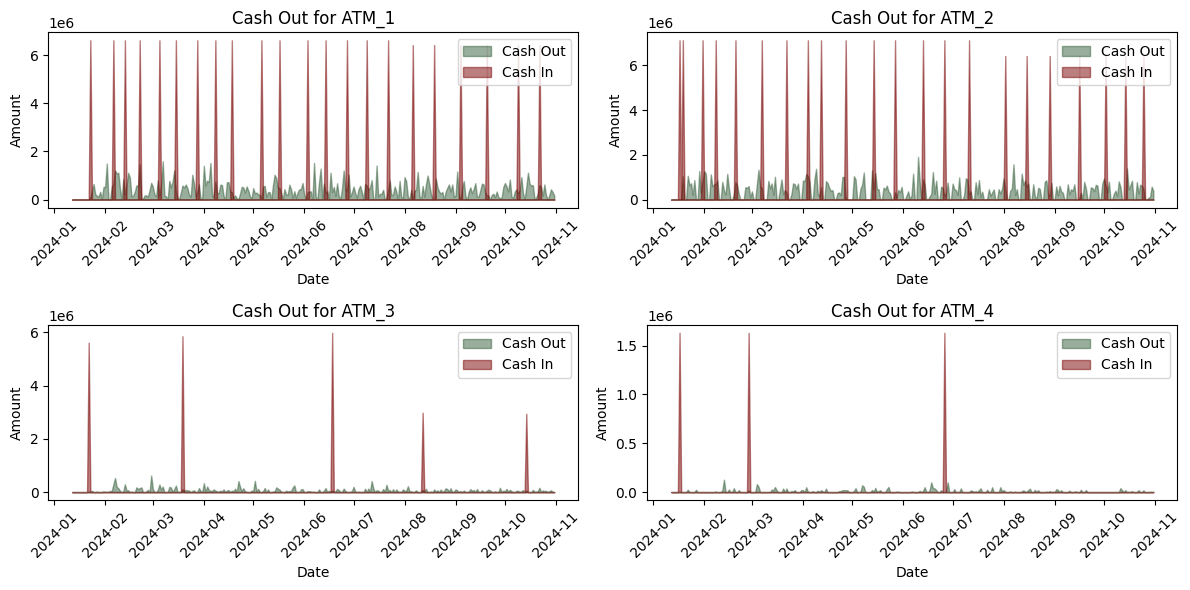

In [17]:
atm_ids = ['ATM_1', 'ATM_2', 'ATM_3', 'ATM_4']
filtered_transactions = transactions[transactions['ATM_ID'].isin(atm_ids)]
transactions.sort_values('date', inplace=True)

plt.figure(figsize=(12, 6))


for i, atm_id in enumerate(atm_ids, start=1):
    plt.subplot(2, 2, i)  # Создаем 2x2 сетку графиков
    atm_data = filtered_transactions[filtered_transactions['ATM_ID'] == atm_id]
    plt.fill_between(atm_data['date'], atm_data['cash_out'], color='#355e3b', alpha=0.5, label='Cash Out')
    plt.fill_between(atm_data['date'], atm_data['cash_in'], color='#780000', alpha=0.5, label='Cash In')
    plt.title(f'Cash Out for {atm_id}')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.legend()
    plt.tight_layout()

plt.show()

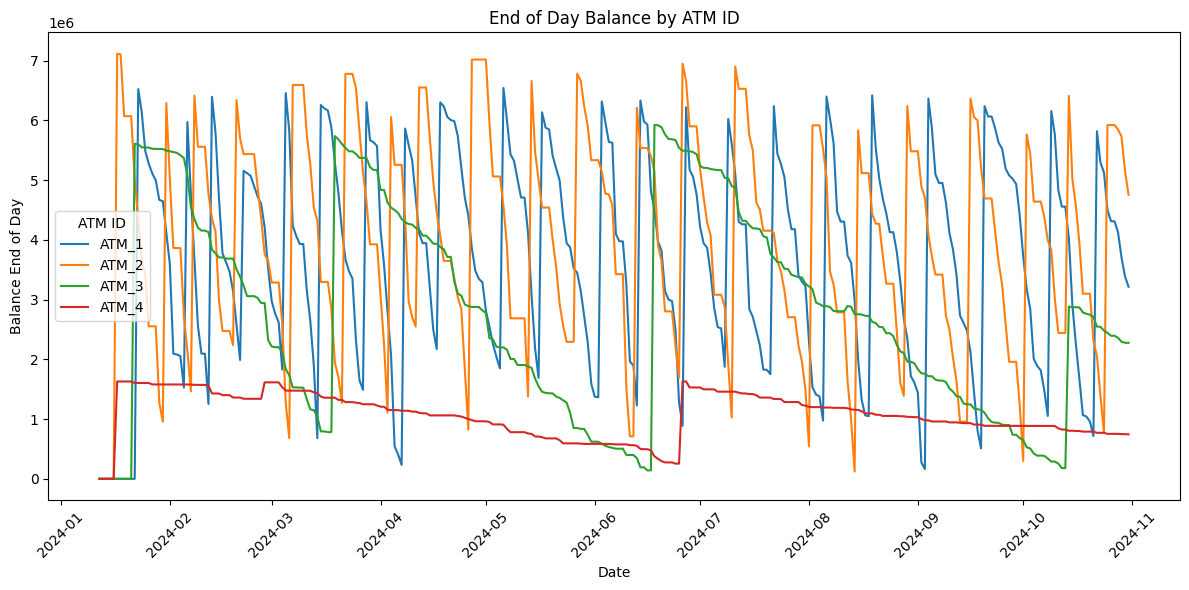

In [18]:
plt.figure(figsize=(12, 6))

for atm_id in atm_ids:
    atm_data = transactions[transactions['ATM_ID'] == atm_id]
    plt.plot(atm_data['date'], atm_data['bal_end_of_day'], label=atm_id)

plt.title('End of Day Balance by ATM ID')
plt.xlabel('Date')
plt.ylabel('Balance End of Day')
plt.xticks(rotation=45)
plt.legend(title='ATM ID')
plt.tight_layout()

plt.show()

In [8]:
transactions['day_of_week'] = transactions['date'].dt.dayofweek
average_cash_out = transactions.groupby(['ATM_ID', 'day_of_week'])['cash_out'].mean().reset_index()
average_cash_out = average_cash_out.sort_values(by=['ATM_ID', 'day_of_week'])
average_cash_out

,ATM_ID,day_of_week,cash_out
0,ATM_1,0,496619.047619
1,ATM_1,1,450745.238095
2,ATM_1,2,429002.380952
3,ATM_1,3,528811.904762
4,ATM_1,4,589323.809524
5,ATM_1,5,168288.095238
6,ATM_1,6,73816.666667
7,ATM_2,0,585026.190476
8,ATM_2,1,537769.047619
9,ATM_2,2,535359.523810


### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


In [10]:
# Определение выходных дней
transactions['weekend'] = transactions['day_of_week'] >= 5
transactions['weekend'] = transactions['weekend'].astype(int)

# Определение праздников
holidays = pd.to_datetime([
    '2024-02-23', '2024-03-08', '2024-05-01', '2024-05-09',
    '2024-06-12', '2024-11-04', '2024-12-31'
]).tz_localize('UTC')
transactions['holiday'] = transactions['date'].isin(holidays).astype(int)

# Определение предпраздничных дней
preholidays = pd.to_datetime([
    '2024-02-22', '2024-02-24', '2024-02-25',
    '2024-03-07', '2024-03-09', '2024-03-10',
    '2024-04-29', '2024-04-30', '2024-05-08',
    '2024-06-11', '2024-11-02', '2024-11-03'
]).tz_localize('UTC')
transactions['preholiday'] = transactions['date'].isin(preholidays).astype(int)

# Функция для вычисления количества дней до ближайшего праздника
def days_to_nearest_holiday(date):
    nearest_holiday = holidays[holidays >= date]
    return (nearest_holiday.min() - date).days

transactions['days_to_holiday'] = transactions['date'].apply(days_to_nearest_holiday)
transactions['atm_code'] = pd.factorize(transactions['ATM_ID'])[0] + 1

In [11]:
# Функция для нормализации
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    return ((series - min_val) / (max_val - min_val)) * 10

transactions['bal_end_of_day'] = normalize_series(transactions['bal_end_of_day'])
transactions['cash_in'] = normalize_series(transactions['cash_in'])
transactions['cash_out'] = normalize_series(transactions['cash_out'])
transactions['days_to_holiday'] = normalize_series(transactions['days_to_holiday'])

In [ ]:
# Удаление дней, когда банкомат простаивал 5 и более дней
transactions['zero_cash_out'] = (transactions['cash_out'] == 0).astype(int)
transactions['streak'] = transactions.groupby('atm_code')['zero_cash_out'].transform(lambda x: x.rolling(window=5).sum())
transactions = transactions[transactions['streak'] < 5]
transactions['streak'] = transactions['streak'].astype(int)
transactions

In [17]:
features = ['bal_end_of_day', 'cash_in', 'cash_out', 'weekend',
            'holiday', 'preholiday', 'days_to_holiday', 'day_of_week', 'atm_code', 'streak']
target = 'cash_out'
# Сначала разделяем данные на обучающую (80%) и временную выборку (20%)
X_train, X_temp, y_train, y_temp = train_test_split(transactions[features], transactions[target], test_size=0.2, random_state=42)

# Затем делим временную выборку на валидационную (70% от 20%) и тестовую (30% от 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

In [18]:
param_grid = {
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'iterations': [100, 250, 300, 420]
}

# Генерация всех комбинаций гиперпараметров
grid = ParameterGrid(param_grid)
best_score = float('inf')
best_model = None
# Обучение модели с каждой комбинацией гиперпараметров
for params in grid:
    model = CatBoostRegressor(iterations=params['iterations'],
                              learning_rate=params['learning_rate'],
                              depth=params['depth'],
                              l2_leaf_reg=params['l2_leaf_reg'],
                              loss_function='RMSE',
                              verbose=0,
                              random_seed=42,
                              task_type="GPU",
                              devices='0')

    # Обучение модели
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val))
    current_score = model.get_best_score()['validation']['RMSE']

    if current_score < best_score - 0.01:
        best_score = current_score
        model.save_model('best_model.cbm')
        print(f"Сохранена лучшая модель с метрикой: {best_score}")

Сохранена лучшая модель с метрикой: 0.14362777363558174
Сохранена лучшая модель с метрикой: 0.12093866960370711
Сохранена лучшая модель с метрикой: 0.10086453159630189
Сохранена лучшая модель с метрикой: 0.08252418876974237


In [15]:
loaded_model = CatBoostRegressor()
loaded_model.load_model('best_model.cbm')
# Удаление выбросов
percentile_99 = transactions['cash_out'].quantile(0.99)
mean_cash_out = loaded_model.predict(transactions[features]).mean()

def remove_outliers(row):
    if row['cash_out'] > percentile_99 and loaded_model.predict(row[features]) < mean_cash_out:
        return False
    if row['weekend'] == 1 and (row['cash_out'] > percentile_99 or loaded_model.predict(row[features]) < mean_cash_out):
        return False
    return True

transactions = transactions[transactions.apply(remove_outliers, axis=1)]

In [75]:
def calculate_streak(row):
    if row['cash_out'] > 0:
        return 0
    else:
        return row.name + 1
# Функция для вычисления дней до ближайшего праздника
def days_to_nearest_holiday(date):
    nearest_holiday = holidays[holidays >= date]
    return (nearest_holiday.min() - date).days
def generate_data(merged_data):
# Добавление новых признаков
  merged_data['date'] = merged_data['date'] + pd.Timedelta(days=1)
  merged_data['cash_in'] = 0
  merged_data['bal_end_of_day'] = merged_data['bal_end_of_day'] - merged_data['cash_out']
  merged_data['streak'] = merged_data.apply(calculate_streak, axis=1)
  merged_data['weekend'] = (merged_data['day_of_week'] >= 5).astype(int)
  merged_data['holiday'] = merged_data['date'].isin(holidays).astype(int)
  merged_data['preholiday'] = merged_data['date'].isin(preholidays).astype(int)
  merged_data['days_to_holiday'] = merged_data['date'].apply(days_to_nearest_holiday)
  return merged_data
# Итеративное предсказание cash_out
predicted_cash_outs = []
dates_start = []
atm_data = []
dates = []
cycle = 10
for index, row in X_test[6:7].iterrows():
  merged_data = pd.merge(row.to_frame().T, transactions[['atm_code', 'days_to_holiday', 'date']],
                       on=['atm_code', 'days_to_holiday'], how='left')
  dates_start.append(merged_data['date'].iloc[-1])
  atm_data.append(merged_data['atm_code'].iloc[-1])
  while row['cash_out'] < row['bal_end_of_day'] and cycle > 0:
    prediction = loaded_model.predict(row[features])
    merged_data['cash_out'] = prediction
    merged_data = merged_data.tail(3)
    merged_data=generate_data(merged_data)
    row = merged_data.iloc[-1]
    predicted_cash_outs.append(merged_data.iloc[-1])
    # row['cash_out'] = prediction
    # row['bal_end_of_day'] -= prediction
    cycle -= 1
  if (len(predicted_cash_outs)>=3):
    dates.append(predicted_cash_outs[-3]['date'])
  else:
    dates.append(merged_data['date'].iloc[-1])
  predicted_cash_outs=[]
df = pd.DataFrame({
    'Start_prediction': dates_start,
    'Date_delivery_collection': dates,
    'Type of ATM':atm_data
})
df

,Start_prediction,Date_delivery_collection,Type of ATM
0,2024-10-03 00:00:00+00:00,2024-10-11 00:00:00+00:00,4.0


Таким образом, обучена модель предсказания снятия денег с банкоматов в день. Также построен алгоритм, который выбирает строку из тестовой выборки и выводит даты для конкретных банкоматов, когда нужно доставлять и менять касеты: строит предсказание снятия каждый день, пока остаток не станет меньше или равен 3 предсказанным снятиям или через 10 дней. Это сделано для того, чтобы успеть предпринять решение и отправить инкассаторскую машину. С помощью подобных решений, так как мой вариант не идеален, можно заработать на деньгах, которые не простаивают в банкоматах, а также расходы на доставку, замену кассеты будут уменьшены для банка.

### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.